# Diagnóstico de Overfitting y Underfitting en Modelos de Machine Learning

Este notebook tiene como objetivo **diagnosticar problemas de overfitting y underfitting** 
utilizando el dataset procesado `df_feat.csv` proveniente de la base MIT-BIH Arrhythmia.  

Se explorarán las características del dataset, se entrenarán modelos base, se generarán 
curvas de aprendizaje (training/validation) y se implementarán estrategias de mejora para 
mitigar problemas detectados.  

---

## Carga y Exploración del Dataset

En esta sección se realiza la carga del dataset preprocesado (`df_feat.csv`) y un análisis 
exploratorio inicial de las características. El objetivo es comprender:

- La dimensión del dataset
- La estructura de las variables
- La distribución de las clases (desbalance o no)
- Valores faltantes o inconsistencias
- Estadísticas descriptivas de las features
- Correlación entre variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Configuración visual
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")
pd.set_option("display.max_columns", None)

In [2]:
# === Carga del dataset ===
df_feat  = pd.read_csv("df_feat_processed.csv")

print("Shape del dataset:", df_feat.shape)
df_feat .head()

Shape del dataset: (112572, 47)


,sample,symbol,class_AAMI,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s,record,class_code,iso_score,iso_dist,lof_score,lof_dist,amp_x_dur,energy_x_mv,log_energy,sqrt_duration,peak_sq,dur_bin,prev_peak,diff_peak_prev,roll_mean_energy_3,roll_std_energy_3,amplitude_peak_std,amplitude_min_std,mean_voltage_std,std_voltage_std,energy_std,area_std,duration_s_std,amplitude_peak_rob,amplitude_min_rob,mean_voltage_rob,std_voltage_rob,energy_rob,area_rob,duration_s_rob,amplitude_peak_qnt,amplitude_min_qnt,mean_voltage_qnt,std_voltage_qnt,energy_qnt,area_qnt,duration_s_qnt
0,100,+,Q,-0.810,-1.000,-0.911550,0.041771,166.533650,0.503806,0.555556,124,2,1,0.077116,-1,3.642141,-0.450000,-151.803749,5.121184,0.745356,0.656100,medium,NaN,NaN,166.533650,NaN,-3.131163,-0.140812,-1.974296,-1.802579,1.108397,1.674411,1.110223e-16,-2.453416,-0.298611,-2.149084,-1.317797,1.735211,1.563322,0.0,-3.127206,-0.399276,-1.718717,-3.016755,1.209953,1.404650,-5.199338
1,102,+,Q,1.650,-0.250,-0.102650,0.276741,17.424500,0.111715,0.555556,217,2,1,0.233167,1,2.566078,0.916667,-1.788625,2.913681,0.745356,2.722500,medium,-0.81,2.460,91.979075,105.436091,0.798792,1.193096,0.727149,-0.474901,-0.617232,-0.945877,1.110223e-16,0.602484,0.743056,0.418801,-0.216025,-0.270935,-0.456442,0.0,0.793602,1.831224,0.923652,-0.330612,-0.959186,-1.275910,-5.199338
2,111,L,N,0.630,-0.700,-0.192800,0.314745,27.247200,0.177111,0.555556,109,1,1,0.227944,1,2.418814,0.350000,-5.253260,3.340994,0.745356,0.396900,medium,1.65,-1.020,70.401783,83.397381,-0.830702,0.392751,0.426080,-0.260163,-0.503555,-0.508845,1.110223e-16,-0.664596,0.118056,0.132616,-0.037826,-0.138779,-0.119570,0.0,-0.924252,0.121995,0.255218,-0.069381,-0.362210,-0.254979,-5.199338
3,124,N,N,0.840,-0.785,-0.062950,0.230911,11.456550,0.103688,0.555556,215,1,1,0.248921,1,0.963826,0.466667,-0.721190,2.522247,0.745356,0.705600,medium,0.63,0.210,18.709417,7.973357,-0.495218,0.241575,0.859734,-0.733857,-0.686299,-0.999526,1.110223e-16,-0.403727,0.000000,0.544830,-0.430920,-0.351230,-0.497796,0.0,-0.520661,-0.015055,1.230052,-0.695618,-1.492115,-1.428830,-5.199338
4,124,N,N,-0.045,-1.190,-0.868375,0.190805,158.096325,0.479938,0.555556,112,1,1,0.144736,1,1.021928,-0.025000,-137.286896,5.069510,0.745356,0.002025,medium,0.84,-0.885,65.600025,80.492300,-1.909043,-0.478735,-1.830106,-0.960476,1.010753,1.514904,1.110223e-16,-1.503106,-0.562500,-2.012024,-0.618979,1.621694,1.440371,0.0,-1.855730,-0.639462,-1.539368,-1.259806,1.133548,1.244457,-5.199338


In [3]:
# === Información general ===
print("\n--- Información del DataFrame ---")
df_feat.info()


--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112572 entries, 0 to 112571
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sample              112572 non-null  int64  
 1   symbol              112572 non-null  object 
 2   class_AAMI          112572 non-null  object 
 3   amplitude_peak      112572 non-null  float64
 4   amplitude_min       112572 non-null  float64
 5   mean_voltage        112572 non-null  float64
 6   std_voltage         112572 non-null  float64
 7   energy              112572 non-null  float64
 8   area                112572 non-null  float64
 9   duration_s          112572 non-null  float64
 10  record              112572 non-null  int64  
 11  class_code          112572 non-null  int64  
 12  iso_score           112572 non-null  int64  
 13  iso_dist            112572 non-null  float64
 14  lof_score           112572 non-null  int64  
 15 

In [4]:
# === Resumen estadístico ===
print("\n--- Resumen estadístico (numérico) ---")
display(df_feat.describe().T)


--- Resumen estadístico (numérico) ---


,count,mean,std,min,25%,50%,75%,max
sample,112572.0,3.256431e+05,1.881329e+05,1.000000e+02,1.624150e+05,3.252575e+05,4.892395e+05,6.498910e+05
amplitude_peak,112572.0,1.149987e+00,6.259641e-01,-4.840000e+00,7.650000e-01,1.165000e+00,1.570000e+00,5.115000e+00
amplitude_min,112572.0,-9.208274e-01,5.622603e-01,-5.120000e+00,-1.220000e+00,-7.850000e-01,-5.000000e-01,4.645000e+00
mean_voltage,112572.0,-3.203820e-01,2.994337e-01,-5.105275e+00,-4.497750e-01,-2.345750e-01,-1.347687e-01,5.059375e+00
std_voltage,112572.0,3.607877e-01,1.769785e-01,1.001249e-02,2.311484e-01,3.228115e-01,4.444135e-01,2.094723e+00
energy,112572.0,7.075865e+01,8.640892e+01,1.431000e-01,2.121923e+01,3.756209e+01,9.554537e+01,5.214410e+03
area,112572.0,2.532528e-01,1.496370e-01,1.192361e-02,1.458194e-01,2.003229e-01,3.399462e-01,2.822042e+00
duration_s,112572.0,5.555556e-01,1.110228e-16,5.555556e-01,5.555556e-01,5.555556e-01,5.555556e-01,5.555556e-01
record,112572.0,1.712028e+02,5.258354e+01,1.000000e+02,1.130000e+02,2.030000e+02,2.170000e+02,2.340000e+02
class_code,112572.0,1.334151e+00,8.196199e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


#### Análisis Resumido del Dataset

- El dataset contiene **112,572 muestras** con múltiples variables de señal y derivadas.  
- **Voltajes y amplitudes** tienen rangos amplios (≈ -5 a +5 mV), reflejando la variabilidad de los latidos.  
- **Duración (`duration_s`)** es constante (0.555 s), por lo que no aporta información relevante.  
- Varias variables están **escaladas/normalizadas** (`*_std`, `*_rob`, `*_qnt`) con media cercana a 0 y desviación ≈ 1.  
- Se observan **outliers** en variables energéticas (`energy`, `energy_x_mv`, `lof_dist`), que podrían influir en el modelado.  
- La variable de clase (`class_code`) muestra **desbalance entre categorías**.  

In [5]:
# === Valores faltantes ===
print("\n--- Conteo de valores nulos por columna ---")
display(df_feat.isnull().sum()[df_feat.isnull().sum() > 0])


--- Conteo de valores nulos por columna ---


prev_peak            1
diff_peak_prev       1
roll_std_energy_3    1
dtype: int64


--- Distribución de clases (AAMI) ---


class_AAMI
F      802
N    90603
Q    11151
S     2781
V     7235
Name: count, dtype: int64

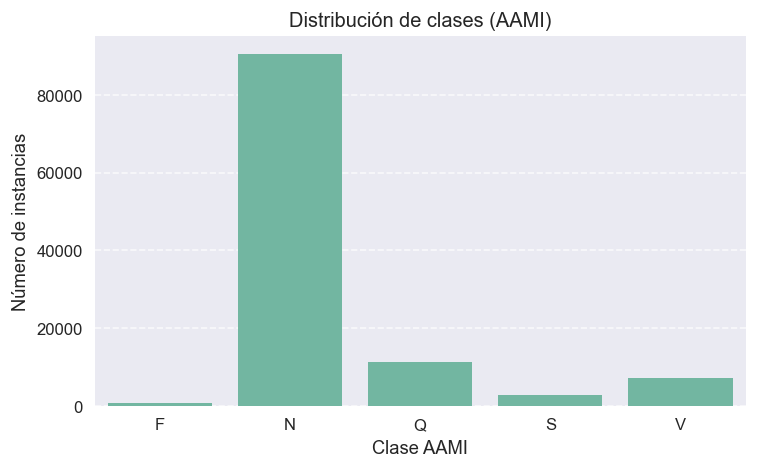

In [6]:
# === Distribución de clases ===
if "class_AAMI" in df_feat.columns:
    class_counts = df_feat["class_AAMI"].value_counts().sort_index()
    print("\n--- Distribución de clases (AAMI) ---")
    display(class_counts)

    plt.figure(figsize=(7,4), dpi=120)
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title("Distribución de clases (AAMI)")
    plt.ylabel("Número de instancias")
    plt.xlabel("Clase AAMI")
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.show()

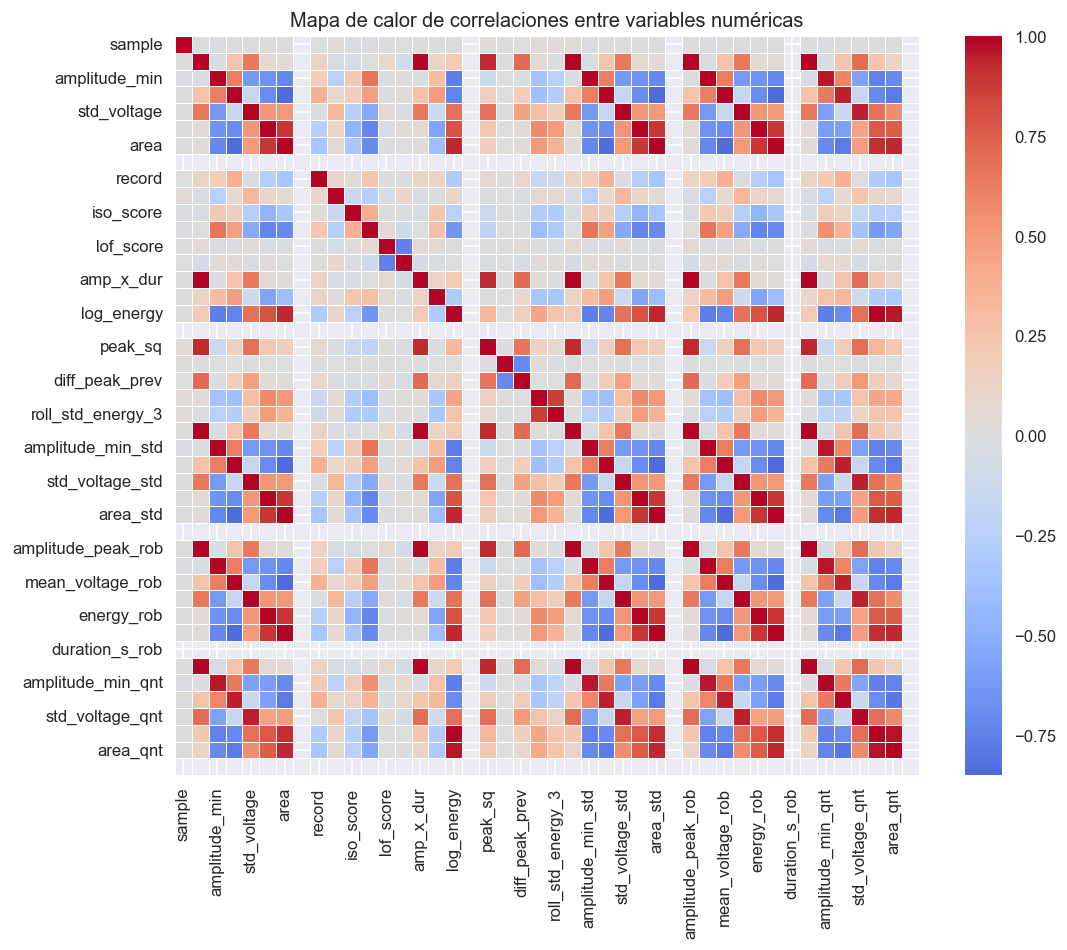

In [7]:
# Correlación entre variables numéricas
num_cols = df_feat.select_dtypes(include=[np.number]).columns
if len(num_cols) > 1:
    corr = df_feat[num_cols].corr()

    plt.figure(figsize=(10,8), dpi=120)
    sns.heatmap(corr, cmap="coolwarm", center=0, 
                annot=False, cbar=True, linewidths=0.5)
    plt.title("Mapa de calor de correlaciones entre variables numéricas")
    plt.show()

#### Análisis del Mapa de Calor de Correlaciones

- El mapa muestra la **relación lineal** entre variables numéricas, con valores entre **-1 y +1**.  
  - **Rojo intenso**: correlación positiva alta.  
  - **Azul intenso**: correlación negativa alta.  
  - **Gris/blanco**: baja correlación.  

#### Observaciones principales
- **Variables derivadas similares** (`*_std`, `*_rob`, `*_qnt`) presentan correlaciones fuertes entre sí → son versiones escaladas o transformadas de la misma señal.  
- **Métricas de energía** (`energy`, `log_energy`, `energy_rob`, `roll_std_energy_3`) están altamente correlacionadas entre sí, lo cual es esperable porque miden aspectos similares.  
- **Amplitud y área** (`amplitude_peak`, `amplitude_min`, `area`) muestran correlaciones moderadas, reflejando la relación natural entre la forma del latido y su área.  
- Variables como **`record`** o **`sample`** casi no se correlacionan con las demás → actúan más como identificadores que como features útiles.  

#### Conclusión
- Existen **grupos de variables redundantes** (energía, amplitud, versiones escaladas).  
- Para evitar problemas de **multicolinealidad** en algunos modelos, puede ser recomendable:  
  - Seleccionar solo una variable representativa por grupo, o  
  - Usar reducción de dimensionalidad (ej. PCA o selección basada en modelos).  

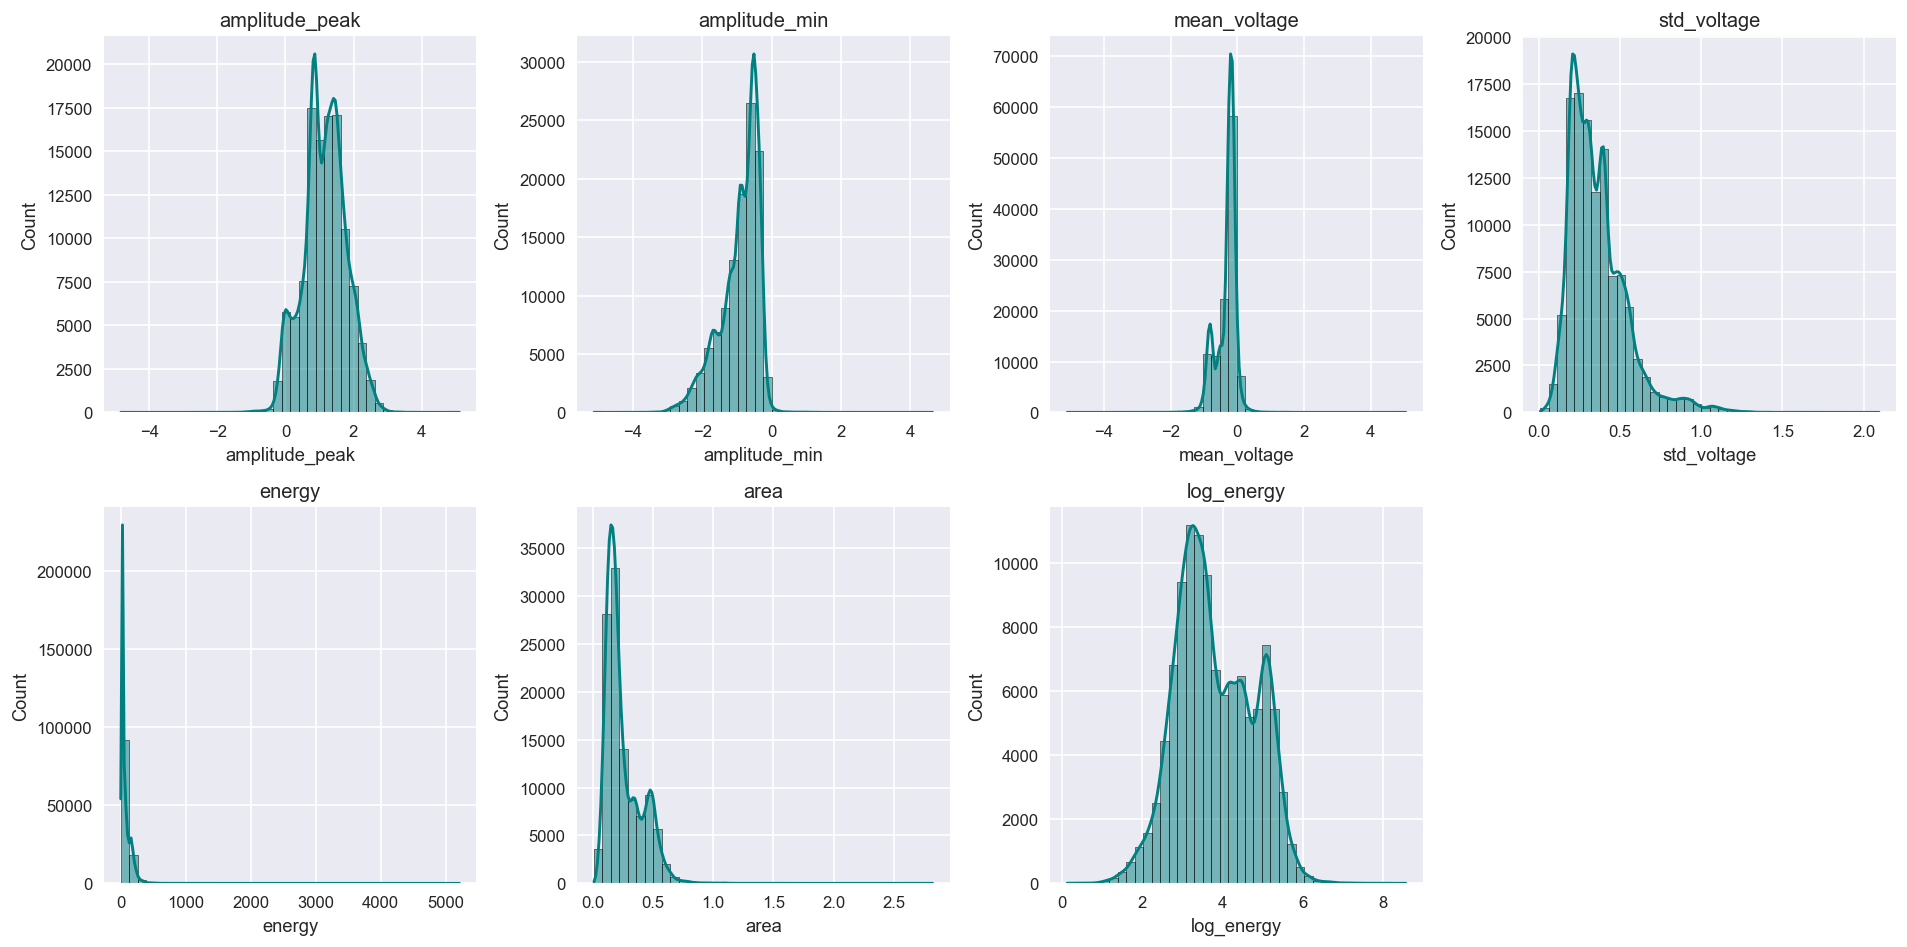

In [8]:
# === Distribuciones univariadas ===

cols_to_plot = [
    "amplitude_peak", "amplitude_min", "mean_voltage", 
    "std_voltage", "energy", "area", "log_energy"
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.histplot(df_feat[col], bins=40, kde=True, ax=axes[i], color="teal")
    axes[i].set_title(col)

# Eliminar el último subplot vacío
for j in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Análisis de Distribuciones Univariadas (variables clave)

- **amplitude_peak / amplitude_min**: distribuciones centradas en torno a 0, con ligera asimetría y colas largas. Reflejan la variabilidad de los picos positivos y negativos de los latidos.  
- **mean_voltage**: concentrado cerca de 0, con pocos casos extremos. Indica que la línea base de la señal está bien centrada tras el preprocesamiento.  
- **std_voltage**: valores principalmente entre 0.2 y 0.6, lo que muestra una variabilidad moderada en los latidos, con pocos outliers más altos.  
- **energy**: muy sesgada a la derecha (muchos valores bajos y algunos extremadamente altos). Esto confirma la necesidad de transformaciones como `log_energy`.  
- **area**: concentrada entre 0 y 0.5, con pocos valores más grandes. Sugiere que la mayoría de los latidos tienen áreas pequeñas bajo la curva.  
- **log_energy**: distribución más balanceada y cercana a normal tras la transformación logarítmica, reduciendo el efecto de outliers.  

**Conclusión**: La mayoría de las variables presentan distribuciones sesgadas con outliers, especialmente en medidas de energía. Transformaciones como el logaritmo ayudan a estabilizar las escalas y mejorar la preparación para el modelado.  

## 1. Implementación de Tracking de Métricas

#### 1.1 Sistema de Monitoreo Básico

In [10]:
# Se prepara los datos (X = features numéricas, y = clases)
X = df_feat.select_dtypes(include=[np.number]).drop(
    columns=["class_code", "record", "sample"], errors="ignore"
)
y = df_feat["class_code"]

# División Train/Test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (90057, 41)  Test: (22515, 41)


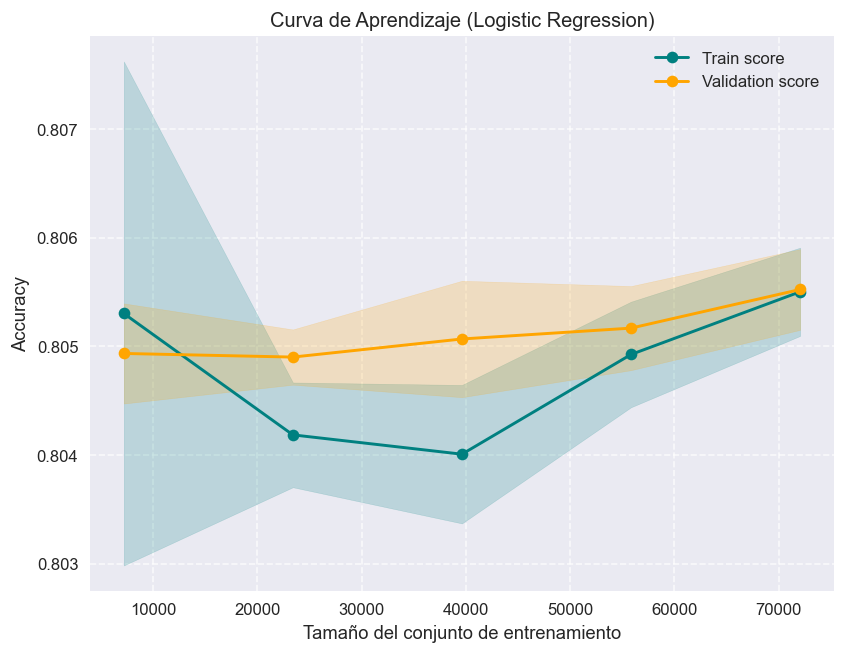

In [11]:
# Modelo base: Regresión Logística
model = LogisticRegression(max_iter=1000, solver="saga", penalty="l2")

# Tracking de métricas con curva de aprendizaje (learning_curve)
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train,
    cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Promedio y desviación
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Gráfico: Accuracy en Train vs Validation según tamaño de datos
plt.figure(figsize=(8,6), dpi=120)
plt.plot(train_sizes, train_mean, "o-", color="teal", label="Train score")
plt.plot(train_sizes, val_mean, "o-", color="orange", label="Validation score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="teal")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2, color="orange")
plt.title("Curva de Aprendizaje (Logistic Regression)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

## Análisis de la Curva de Aprendizaje (1.1)

- La **accuracy en entrenamiento (línea verde/teal)** y la **accuracy en validación (línea naranja)** son muy similares en todo el rango de tamaños de datos.  
- El **gap entre train y validation es mínimo** → no se observa un patrón de overfitting (donde train sería muy alto y validation bajo).  
- Tampoco se ve underfitting severo → ambos conjuntos alcanzan un accuracy estable alrededor de **0.805**.  
- El modelo converge rápido y no mejora mucho con más datos → típico de modelos lineales como Logistic Regression, que tienen capacidad limitada para capturar patrones muy complejos.  

**Conclusión:** El modelo base (Logistic Regression) muestra un **comportamiento estable y balanceado**, sin evidencias claras de overfitting ni underfitting, pero con un techo de rendimiento cercano a **80.5% de accuracy**.  


#### 1.2 Tracking para Diferentes Tipos de Modelos (Scikit-learn)

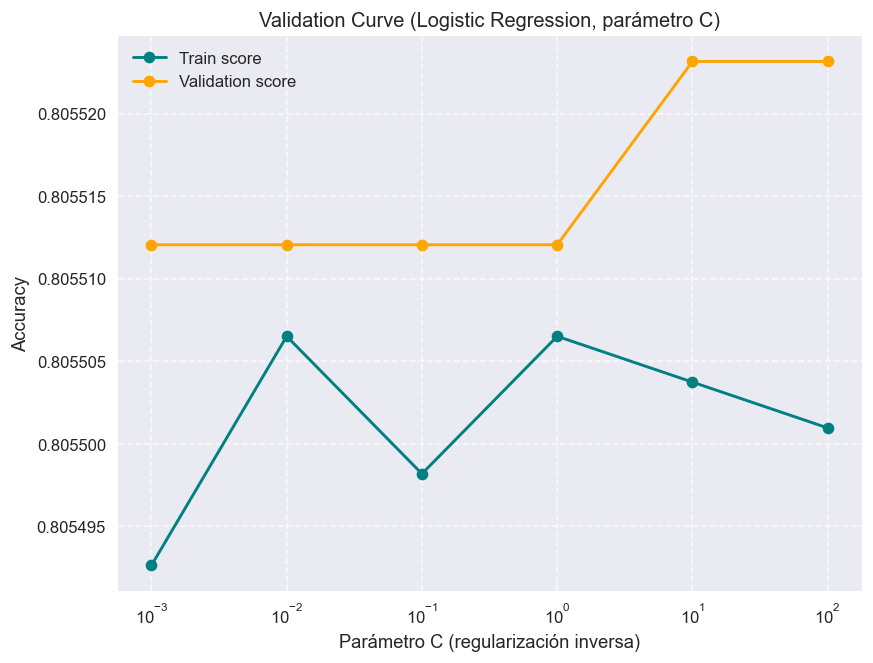

In [12]:
# Se usa validation_curve para ver el efecto de un hiperparámetro (C)
param_range = np.logspace(-3, 2, 6)  # valores de C para regularización

train_scores, val_scores = validation_curve(
    model, X_train, y_train,
    param_name="C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

# Promedio de scores
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Gráfico: Accuracy en Train vs Validation según C
plt.figure(figsize=(8,6), dpi=120)
plt.semilogx(param_range, train_mean, "o-", color="teal", label="Train score")
plt.semilogx(param_range, val_mean, "o-", color="orange", label="Validation score")
plt.title("Validation Curve (Logistic Regression, parámetro C)")
plt.xlabel("Parámetro C (regularización inversa)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()